### Assignment Three

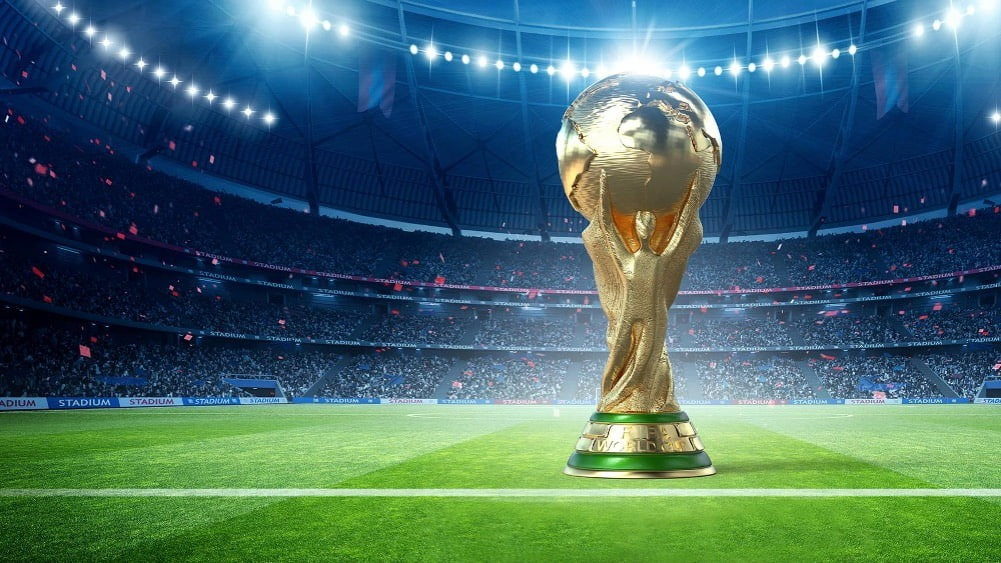

# FIFA World Cup Predection

Author: **Chadrack Kavula Mulamba**  
Date: **13 September 2023**
Source_1:**https://www.kaggle.com/datasets/cashncarry/fifaworldranking**
Source_2:**https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?resource=download&select=goalscorers.csv**
Source_3:**https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?resource=download&select=results.csv**
Source_4:**https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?resource=download&select=shootouts.csv**
Github url: **https://github.com/chadrack-123/WC_Prediction** 

Who does not like football (soccer) especially the world cup, We are going to try to predict the winner of the next world cup

Importing all the neccessaries libraries

In [106]:
import numpy as np 
import pandas as pd 
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from operator import itemgetter
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import warnings
warnings.filterwarnings('ignore')


Reading the data & Cleanning it

In [2]:
df =  pd.read_csv("results.csv")

In [3]:
df["date"] = pd.to_datetime(df["date"])

In [4]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

<br/>

The dataset that will be used will be the FIFA Games between 2006, from after the 2006 World Cup to the lastest games of July 2023 . The idea is to analyze just the games played at the preparation and classification to World Cup.

In [7]:
df.sort_values("date").head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [8]:
df = df[(df["date"] >= "2006-7-9")].reset_index(drop=True)

In [9]:
df.sort_values("date").head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2006-07-09,Italy,France,1,1,FIFA World Cup,Berlin,Germany,True
1,2006-07-15,Syria,Iraq,1,3,Friendly,Damascus,Syria,False
2,2006-07-15,Zambia,Zimbabwe,0,0,Friendly,Lusaka,Zambia,False
3,2006-07-17,Ethiopia,Yemen,1,0,Friendly,Addis Ababa,Ethiopia,False
4,2006-07-21,Jordan,Iraq,2,1,Friendly,Amman,Jordan,False


In [10]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
15945,2023-07-09,United States,Canada,2,2,Gold Cup,Cincinnati,United States,False
15946,2023-07-12,United States,Panama,1,1,Gold Cup,San Diego,United States,False
15947,2023-07-12,Jamaica,Mexico,0,3,Gold Cup,Paradise,United States,True
15948,2023-07-16,Kernow,Sápmi,2,1,CONIFA World Football Cup qualification,Falmouth,England,False
15949,2023-07-16,Mexico,Panama,1,0,Gold Cup,Inglewood,United States,True


In [18]:
df.describe()

,home_score,away_score
count,15950.000000,15950.000000
mean,1.598182,1.097994
std,1.629016,1.333053
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,21.000000,20.000000


In [11]:
df.home_team.value_counts()

Mexico                       184
United States                178
Qatar                        169
Japan                        164
South Africa                 148
                            ... 
Madrid                         1
Saint Pierre and Miquelon      1
Canary Islands                 1
Silesia                        1
Ticino                         1
Name: home_team, Length: 295, dtype: int64

Loading the fifa rank dataset

In [12]:
rank = pd.read_csv("fifa_ranking-2023-07-20.csv")

In [13]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2006-7-9")].reset_index(drop=True)

In [14]:
rank.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,141,Vietnam,VIE,116.0,353.0,15,AFC,2006-07-12
1,194,Cook Islands,COK,3.0,61.0,-1,OFC,2006-07-12
2,193,Bahamas,BAH,7.0,64.0,-1,CONCACAF,2006-07-12
3,192,Philippines,PHI,9.0,84.0,1,AFC,2006-07-12
4,191,San Marino,SMR,12.0,229.0,30,UEFA,2006-07-12


<br/>
Some teams have different names in the ranking's dataset. So, let's fix it.

In [15]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

In [16]:
rank.tail()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
37222,66,Cabo Verde,CPV,1354.65,1354.65,0,CAF,2023-07-20
37223,67,Iceland,ISL,1352.98,1352.98,0,UEFA,2023-07-20
37224,68,North Macedonia,MKD,1350.53,1350.53,0,UEFA,2023-07-20
37225,58,Jamaica,JAM,1409.73,1367.83,-5,CONCACAF,2023-07-20
37226,205,US Virgin Islands,VIR,816.59,816.59,-3,CONCACAF,2023-07-20


In [17]:
rank.describe()

,rank,total_points,previous_points,rank_change
count,37227.000000,37227.000000,37227.000000,37227.000000
mean,102.751471,588.307029,588.243265,0.006447
std,59.106883,464.024520,463.448614,6.308902
min,1.000000,1.000000,0.000000,-82.000000
25%,52.000000,191.000000,192.000000,-1.000000
50%,103.000000,457.000000,458.000000,0.000000
75%,154.000000,940.890000,940.000000,1.000000
max,211.000000,2172.000000,2187.000000,199.000000


<br/>
The merge is made in order to get a dataset FIFA games and its rankings.

In [19]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
13129,2022-09-23,Brazil,Ghana,3,0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1393.47,1389.68,60.0,0.0
13197,2022-09-27,Brazil,Tunisia,5,1,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1507.86,1507.86,30.0,0.0
13332,2022-11-24,Brazil,Serbia,2,0,FIFA World Cup,Lusail,Qatar,True,1841.30,1837.56,1.0,0.0,1563.62,1549.53,21.0,-4.0
13348,2022-11-28,Brazil,Switzerland,1,0,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1635.92,1621.43,15.0,-1.0
13364,2022-12-02,Cameroon,Brazil,1,0,FIFA World Cup,Lusail,Qatar,True,1471.44,1484.95,43.0,5.0,1841.30,1837.56,1.0,0.0
13372,2022-12-05,Brazil,South Korea,4,1,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1530.30,1526.02,28.0,0.0
13375,2022-12-09,Croatia,Brazil,1,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,1632.15,12.0,-3.0,1841.30,1837.56,1.0,0.0
13485,2023-03-25,Morocco,Brazil,2,1,Friendly,Tangier,Morocco,False,1672.35,1563.50,11.0,-11.0,1840.77,1841.30,1.0,0.0
13626,2023-06-17,Brazil,Guinea,4,1,Friendly,Barcelona,Spain,True,1834.21,1840.77,3.0,2.0,1305.92,1290.47,79.0,-4.0
13666,2023-06-20,Brazil,Senegal,2,4,Friendly,Lisbon,Portugal,True,1834.21,1840.77,3.0,2.0,1613.21,1603.98,18.0,-1.0


<br/>

Now, we have the data ready to create features based on the games' results and FIFA rankings.

### *Features Engineering*

The idea here is to create possible features that have impact on predicting football games. By intuition, we say that features that impact could be: <br/>

 - Past game points made
 - Past goals scored and suffered
 - The importance of game (friendly or not)
 - Rank of the teams
 - Rank increasement of the teams
 - Goals made and suffered by ranking faced

So, the first thing to do is create the feature that says which team won and how much points they made at game.

In [20]:
df = df_wc_ranked

In [21]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

df[["result", "home_team_points", "away_team_points"]] = results

The game points are 3 for win, 1 for draw and 0 for lose and are different than the FIFA rank points that are already in the database. Also, it's supposed that FIFA Rank points and FIFA Ranking of the same team are negative correlated, and we should use only one of them to create new features. This supposition is checked below:

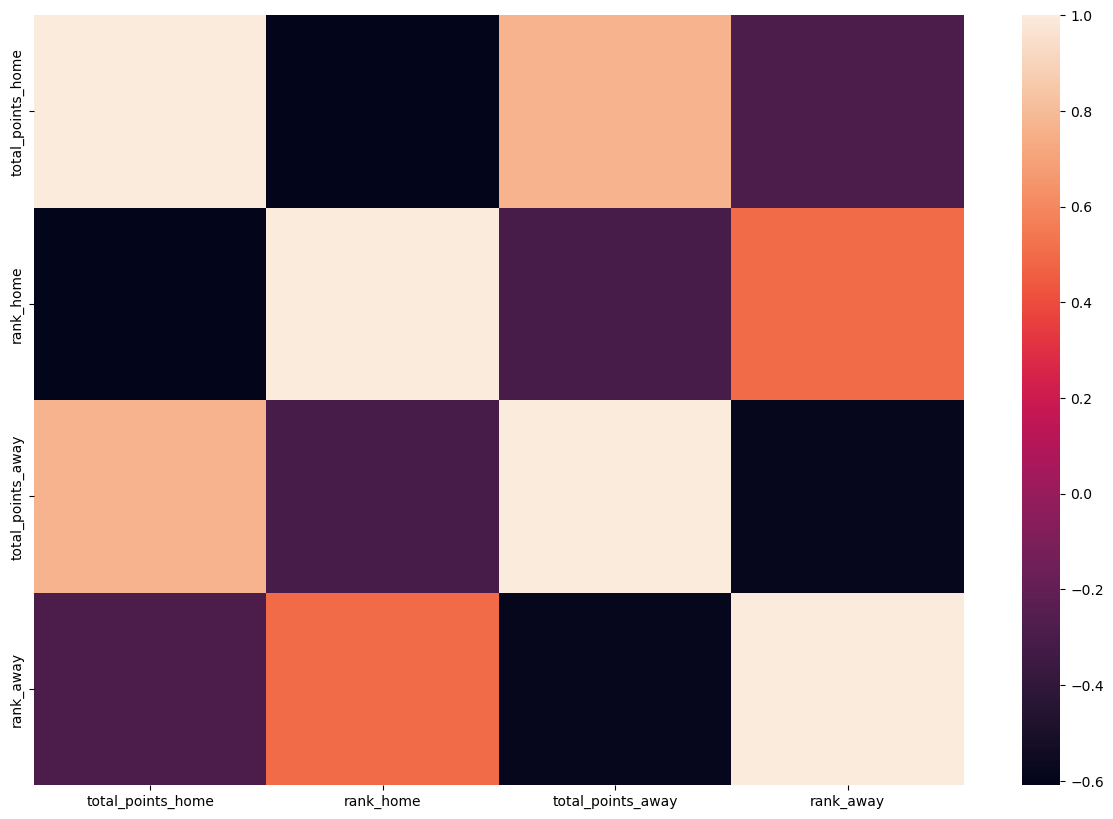

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

Now, we create columns that will help in the creation of the features: ranking difference, points won at the game vs. team faced rank, and goals difference in the game. All features that are not differences should be created for the two teams (away and home).

In [23]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In order to create the features, I'll separate the dataset in home team's and away team's dataset, unify them and calculate the past game values. After that, I'll separate again and merge them, retrieving the original dataset. This proccess optimizes the creation of the features.

In [24]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [25]:
team_stats = pd.concat([home_team, away_team], ignore_index=True)

#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Now, we have a database ready to create predictive features. They will be:

 - Mean goals of the team in World Cup Cycle.
 - Mean goals of the team in last 5 games.
 - Mean goals suffered of the team in World Cup Cycle.
 - Mean goals suffered of the team in last 5 games.
 - Mean FIFA Rank that team faced in World Cup Cycle.
 - Mean FIFA Rank that team faced in last 5 games.
 - FIFA Points won at the cycle.
 - FIFA Points won in last 5 games.
 - Mean game points at the Cycle.
 - Mean game points at last 5 games.
 - Mean game points by rank faced at the Cycle.
 - Mean game points by rank faced at last 5 games.

In [26]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [27]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

The new columns:

In [28]:
home_team_stats.columns[-12:]
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In order to unify the database, we need to add home and away suffix for each column. After that, the data is ready to be merged.

In [29]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [30]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Now, to quantify game importance, is created a column that finds competition of the game.

In [31]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [32]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

And, after that, we only select columns that will help in Features' analysis.

In [33]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
13720,2023-07-09,Guatemala,Jamaica,116.0,63.0,0,1,1,53.0,0.0,...,1.308725,1.4,0.015783,0.023465,1.318681,1.0,0.020122,0.034487,1,0
13721,2023-07-09,United States,Canada,11.0,45.0,2,2,2,-34.0,-2.0,...,1.806202,2.2,0.083987,0.075214,1.443662,2.0,0.024817,0.023091,1,0
13722,2023-07-12,United States,Panama,11.0,57.0,1,1,2,-46.0,-2.0,...,1.803089,2.2,0.083748,0.066326,1.394619,1.4,0.026915,0.028361,1,0
13723,2023-07-12,Jamaica,Mexico,63.0,14.0,0,3,1,49.0,0.0,...,1.327869,1.4,0.020153,0.026326,1.840278,2.4,0.073035,0.039027,1,0
13724,2023-07-16,Mexico,Panama,14.0,57.0,1,0,0,-43.0,-1.0,...,1.844291,2.4,0.072947,0.038206,1.392857,1.6,0.027201,0.046543,1,0


In [34]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                   96
home_goals_mean_l5                96
home_goals_suf_mean               96
home_goals_suf_mean_l5            96
home_rank_mean                    96
home_rank_mean_l5                 96
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  104
away_goals_mean_l5               104
away_goals_suf_mean              104
away_goals_suf_mean_l5           104
away_rank_mean                   104
away_rank_mean_l5                104
away_points_mean                   0
away_points_mean_l5                0
h

The games with NA are the ones who mean could not be calculated (games from the beginning of the dataset). Let's drop them.

In [35]:
base_df_no_fg = base_df.dropna()

### Data Analysis

Our next step involves a thorough analysis of the newly created features to determine their predictive capabilities. If they do not exhibit significant predictive power, we will explore the option of crafting additional features, such as home team - away team differences. To assess predictive strength, we will approach the problem by reclassifying draw games as losses for the home team, thereby transforming it into a binary classification challenge.

In [47]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x

# Use .loc to set values in the original DataFrame
df.loc[:, "target"] = df["result"].apply(lambda x: no_draw(x))

Analysis that will be made:

 - Violin and boxplot to analyze if the features have different distributions according to the target
 - Scatter plots to analyze correlations

In [51]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

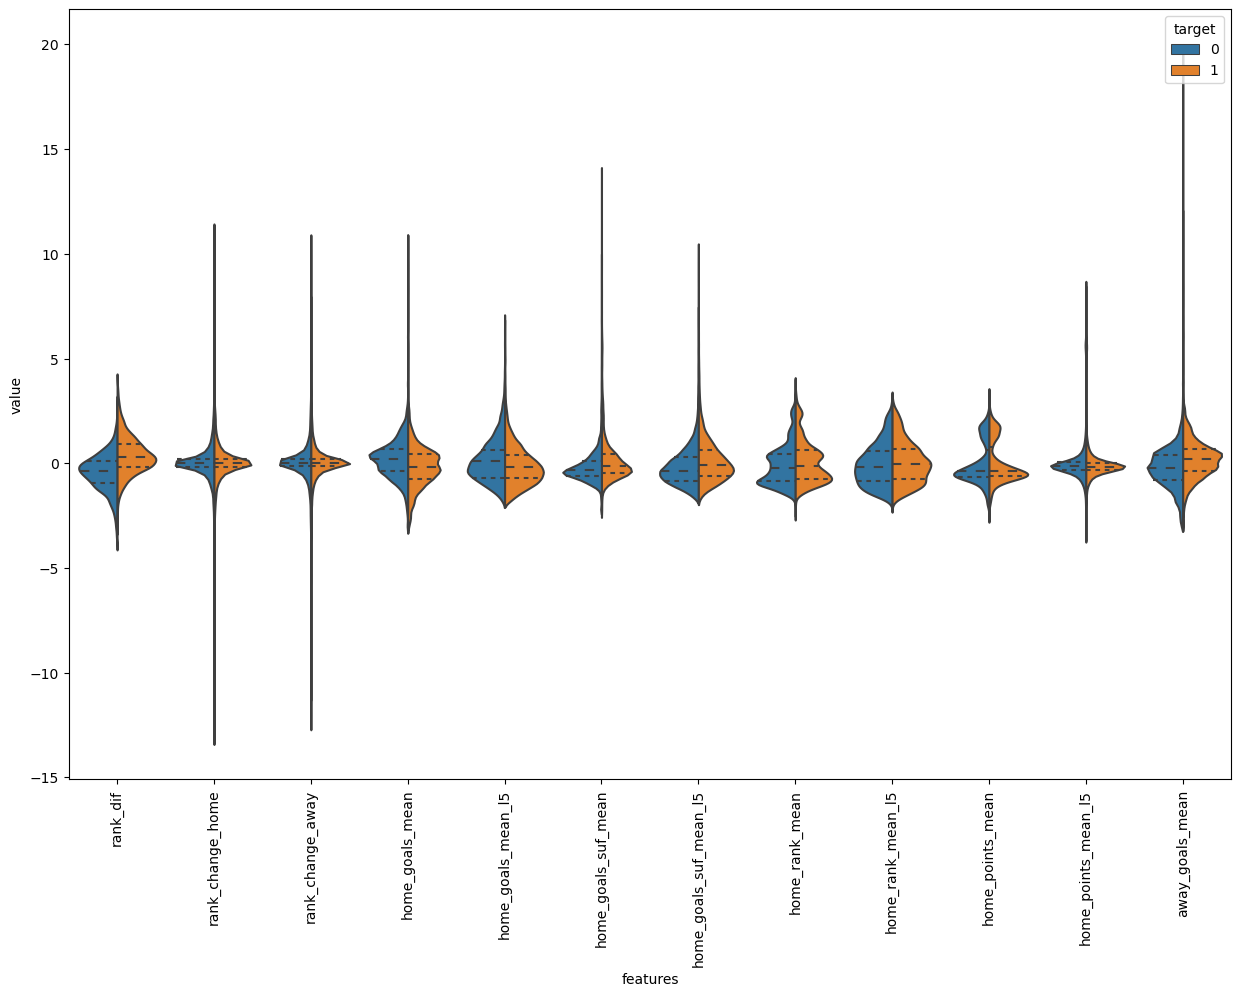

In [52]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

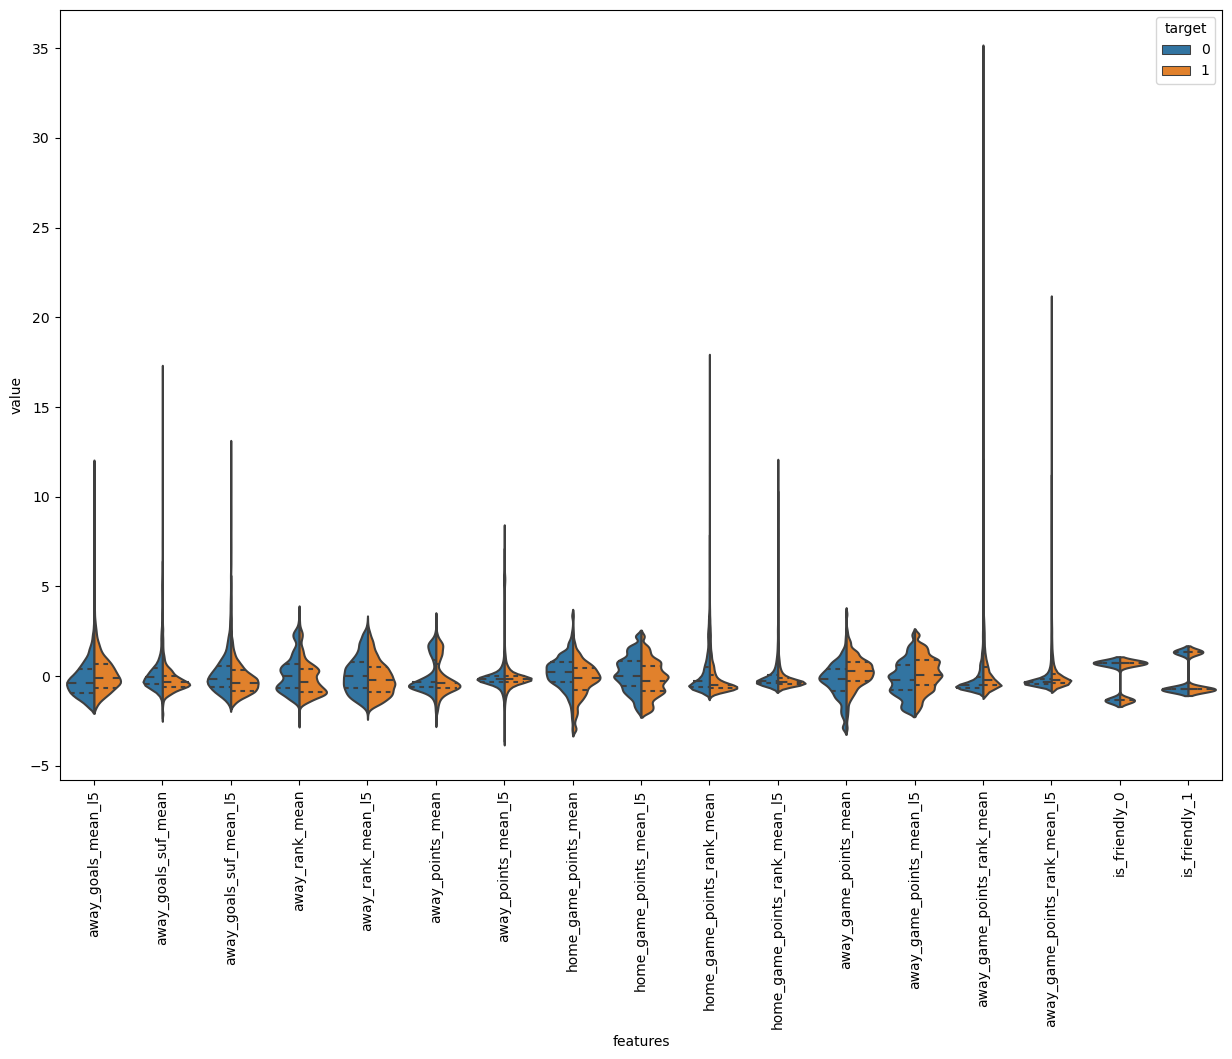

In [53]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Based on the plots, we've identified that the rank difference stands out as the most effective feature for data separation. However, we can explore the creation of new features that capture the disparities between the home and away teams and assess their potential for improving data separation.

In [54]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

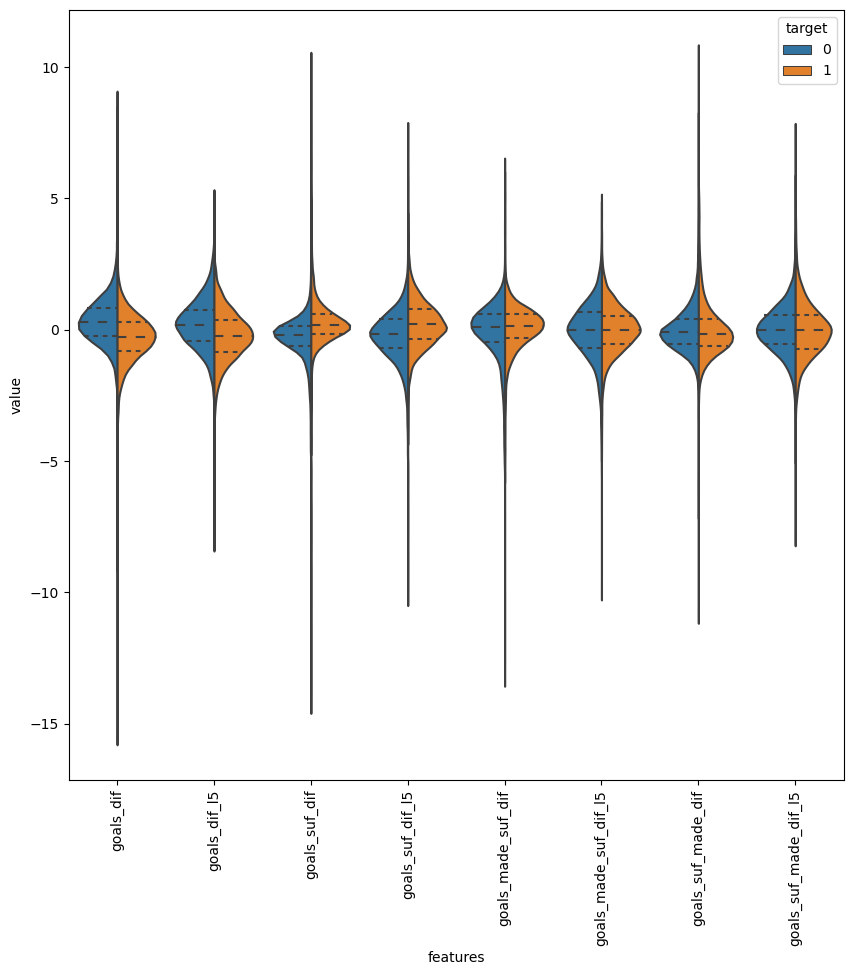

In [55]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With that plot, we see that goal differences are good separator, and goals suffered difference too. Differences between goals made and goals suffered of the teams are not very good separators.

Now, we have 5 features:

 - rank_dif
 - goals_dif
 - goals_dif_l5
 - goals_suf_dif
 - goals_suf_dif_l5

We can create other features, like differences of points made, differences of points made by rank faced and differences of rank faced.

In [56]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [57]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Also, we can calculate goals made and suffered by rank, and check this difference.

In [58]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

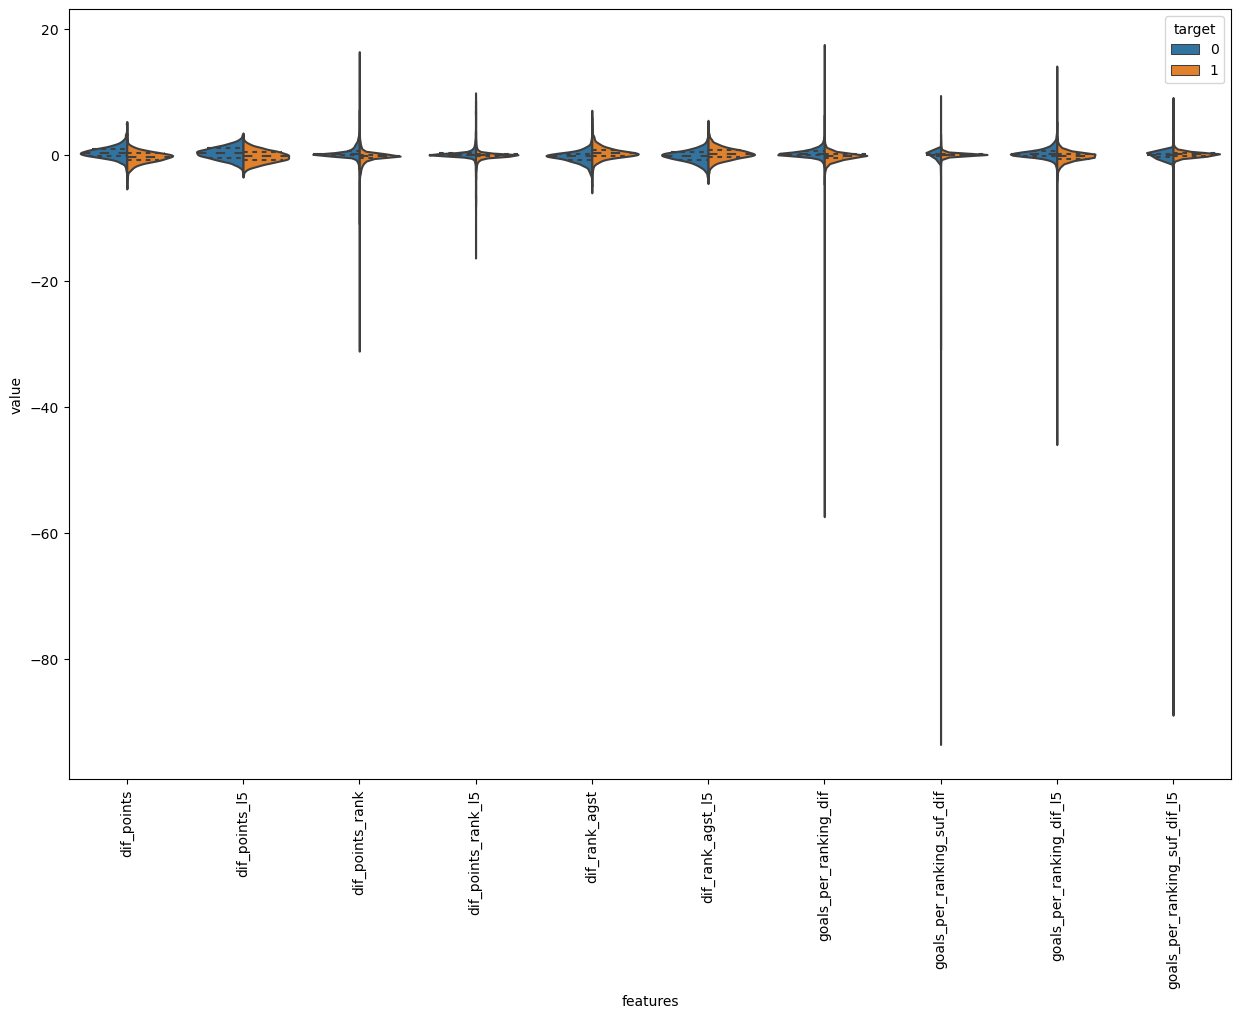

In [59]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Considering the relatively small values, the violin plot wasn't the most suitable choice for evaluating whether the features effectively separate the data in this scenario. Instead, we'll turn to the boxplot for a clearer analysis.

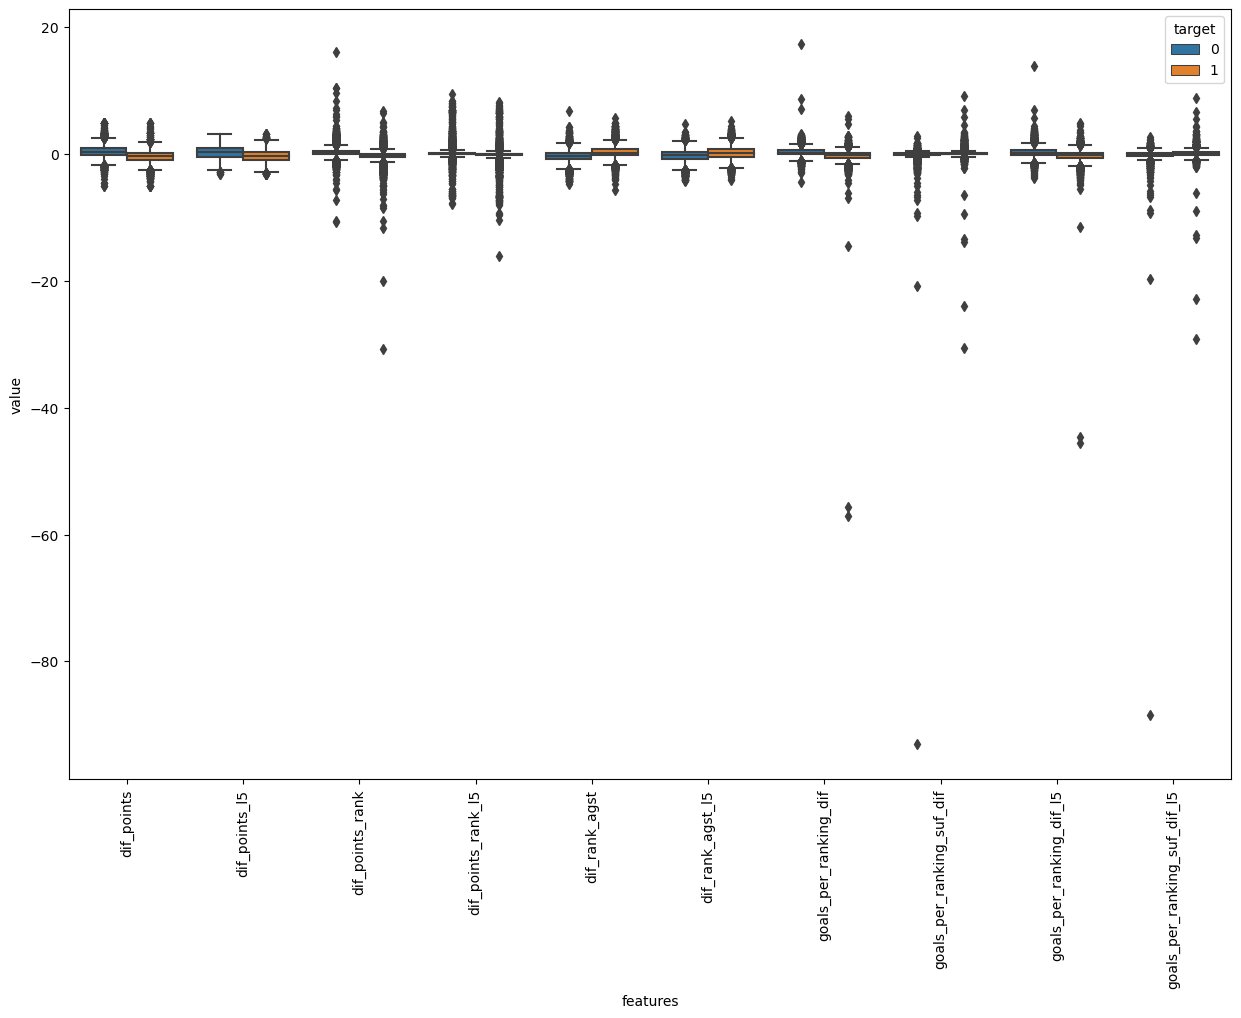

In [60]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

Difference of points (full and last 5 games), difference of points by ranking faced (full and last 5 games) and difference of rank faced (full and last 5 games) are good features. Also, some of the generated features have very similar distributions which will be analyzed using scatterplots.

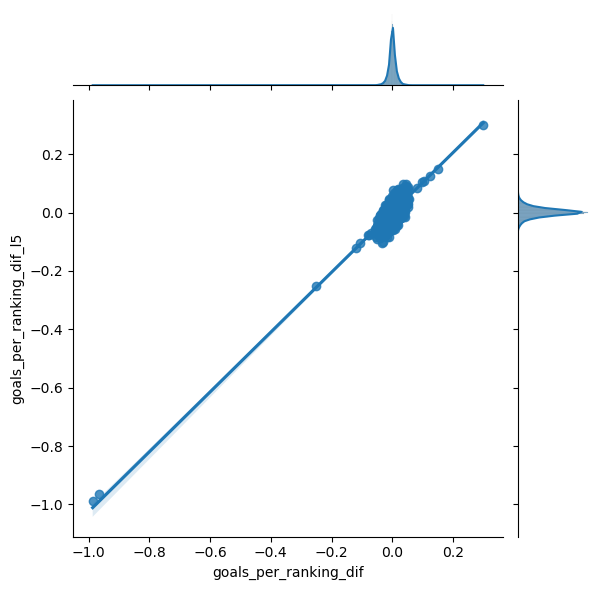

In [61]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

Goals difference by ranking faced and its last 5 games version has very similar distributions. So, we will use only the full version (goals_per_ranking_dif).

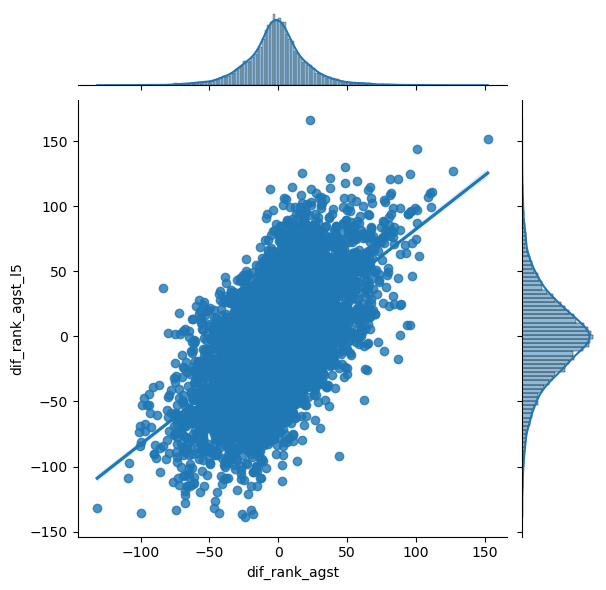

In [62]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

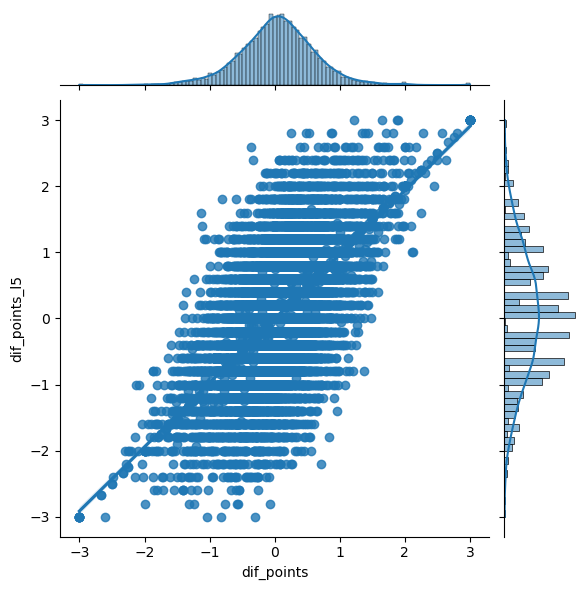

In [63]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

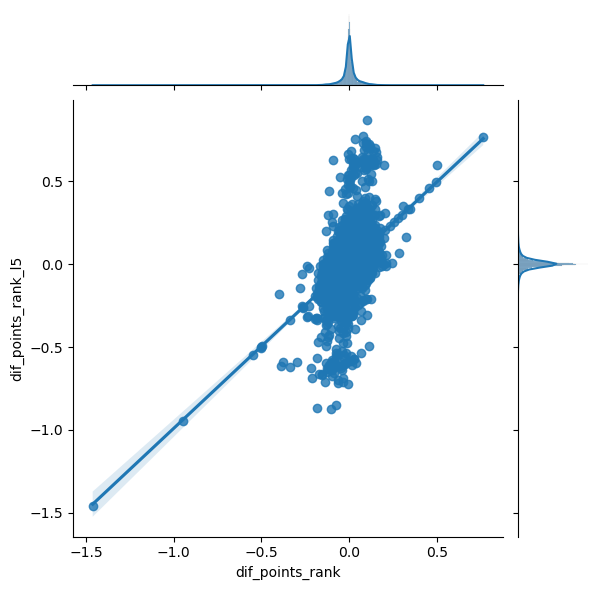

In [64]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

For the differences of rank faced, game points by rank faced and mean game points by rank faced, the two versions (full and 5 games) are not so similar. So, we will use both.

Based on that, final features are:

 - rank_dif
 - goals_dif
 - goals_dif_l5
 - goals_suf_dif
 - goals_suf_dif_l5
 - dif_rank_agst
 - dif_rank_agst_l5
 - goals_per_ranking_dif
 - dif_points_rank
 - dif_points_rank_l5
 - is_friendly

In [65]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [68]:
model_dataset = create_db(df)

In [69]:
model_dataset

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
6,Namibia,Malawi,0,87.0,0.000000,0.0,-2.000000,-2.000000,-0.009037,79.000000,79.0,0.007092,0.007092,1,0
7,Seychelles,Zambia,1,79.0,-0.500000,-0.5,0.500000,0.500000,-0.014560,94.000000,94.0,-0.020338,-0.020338,1,0
8,Syria,Iraq,1,22.0,-1.000000,-1.0,1.500000,1.500000,-0.007867,-16.000000,-16.0,-0.013636,-0.013636,0,1
10,Jordan,Syria,0,-12.0,1.000000,1.0,-1.500000,-1.500000,0.011364,0.000000,0.0,0.034091,0.034091,0,1
16,Jordan,Iraq,1,10.0,0.500000,0.5,-0.833333,-0.833333,0.006385,-7.000000,-7.0,0.012500,0.012500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13720,Guatemala,Jamaica,1,53.0,-0.009293,-1.4,0.015119,-1.200000,-0.003009,15.941072,26.2,-0.004339,-0.011022,1,0
13721,United States,Canada,1,-34.0,0.228682,0.6,-0.052790,-0.600000,0.015275,-24.884267,-38.6,0.059170,0.052124,1,0
13722,United States,Panama,1,-46.0,0.451703,1.2,-0.190713,-0.600000,0.015160,-13.618003,7.2,0.056833,0.037965,1,0
13723,Jamaica,Mexico,1,49.0,-0.433686,-0.4,0.251309,0.800000,-0.016294,23.992771,10.6,-0.052882,-0.012701,1,0


### The model

Now that we have a dataset that is ready and with columns with predictive power, we can start our modelling.

Two models will be tested: Random Forest and Gradient Boosting. The selected will be the one with best recall.

A bit of explanation about the model

**Random Forest**: a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.

**Gradient Boosting**: is a popular boosting algorithm in machine learning used for classification and regression tasks. Boosting is one kind of ensemble Learning method which trains the model sequentially and each new model tries to correct the previous model. It combines several weak learners into strong learners.

In [70]:
X = model_dataset.iloc[:, 3:]
y = model_dataset[["target"]]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [72]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [73]:
gb = gb_cv.best_estimator_

In [74]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [75]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [76]:
rf = rf_cv.best_estimator_

In [77]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [78]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

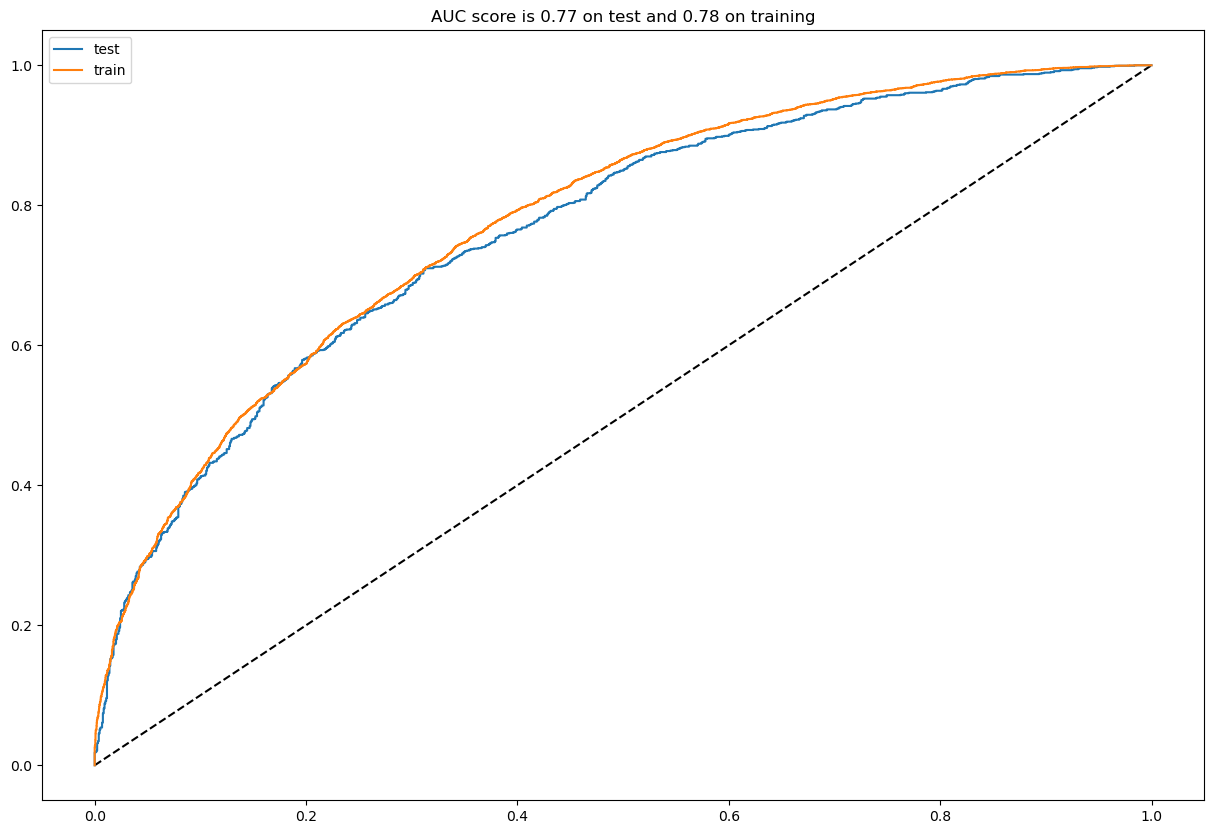

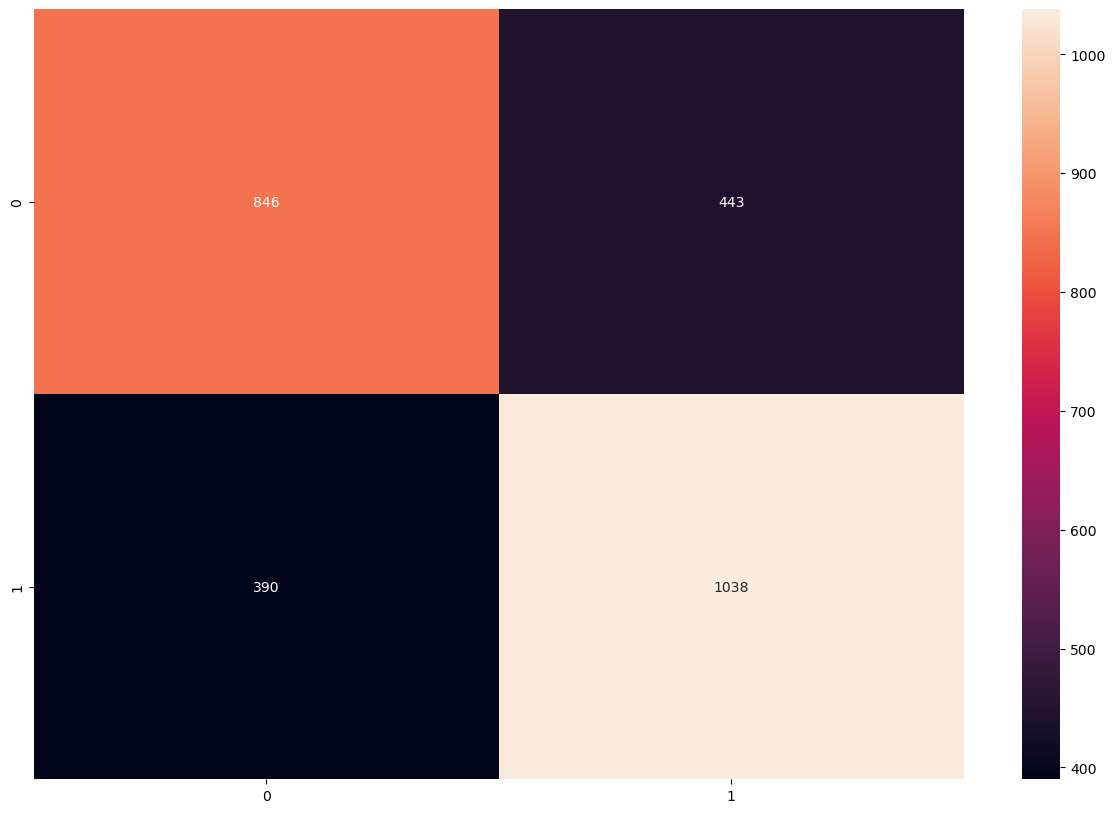

In [79]:
analyze(gb)

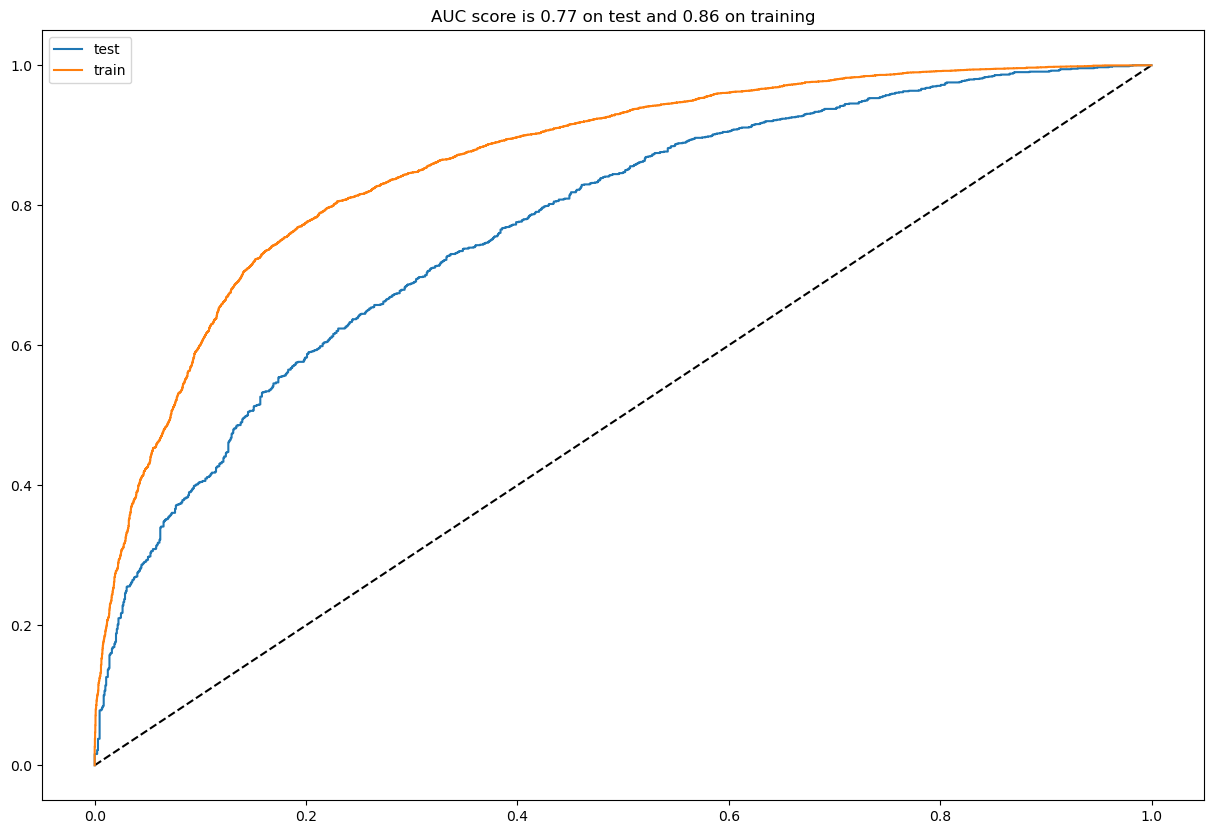

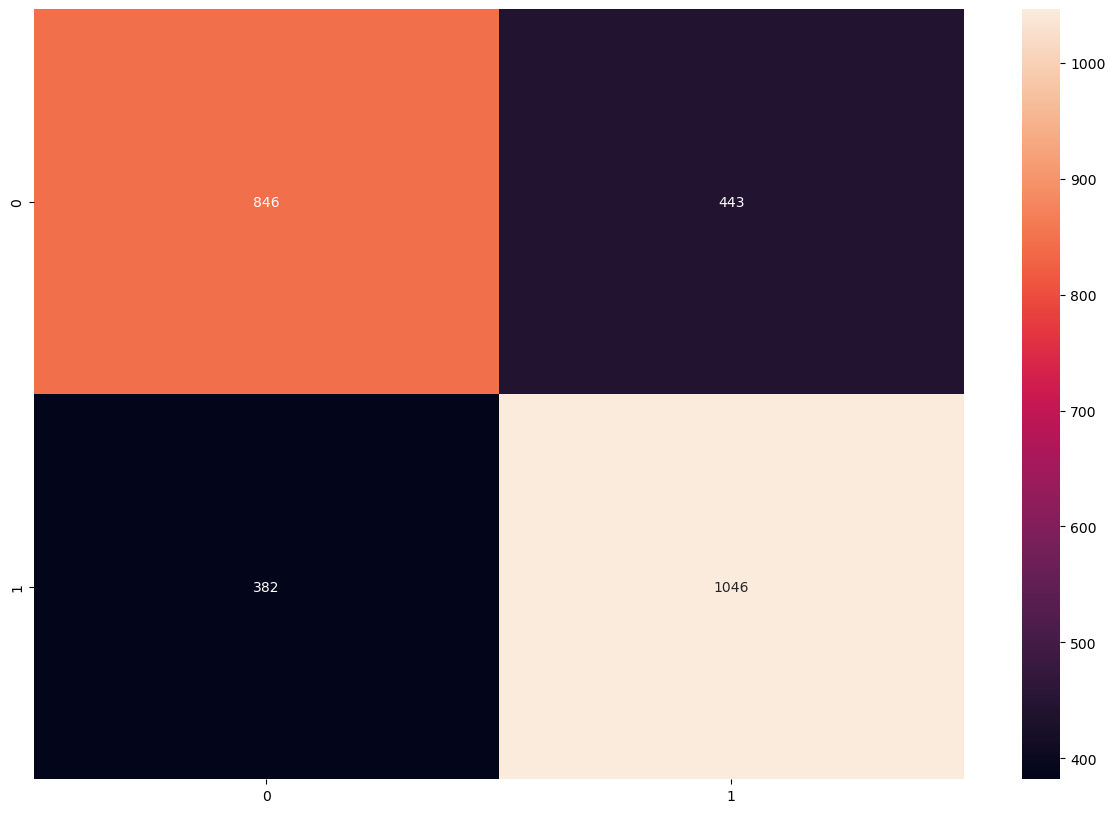

In [80]:
analyze(rf)

The Random Forest model is a little bit better but seems to underfit. So, we will use the Gradient Boosting Model.

### WC 2026 Simulation

The first thing is to create FIFA World Cup games. To do this, I'll randomly assign teams based on the information available for the world cup.

In [81]:
table ={'A': [['Canada', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['United States', 0, []],
  ['Iran', 0, []],
  ['England', 0, []],
  ['Wales', 0, []]],
 'C': [['Mexico', 0, []],
  ['Saudi Arabia', 0, []],
  ['Costa Rica', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Argentina', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Qatar', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}


In [82]:
table

{'A': [['Canada', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['United States', 0, []],
  ['Iran', 0, []],
  ['England', 0, []],
  ['Wales', 0, []]],
 'C': [['Mexico', 0, []],
  ['Saudi Arabia', 0, []],
  ['osta Rica', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Argentina', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Qatar', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [95]:
matches = [
    ('A', 'Canada', 'Ecuador'),
    ('A', 'Senegal', 'Netherlands'),
    ('A', 'Canada', 'Senegal'),
    ('A', 'Netherlands', 'Ecuador'),
    ('A', 'Ecuador', 'Senegal'),
    ('A', 'Netherlands', 'Canada'),
    ('B', 'United States', 'Iran'),
    ('B', 'England', 'Wales'),
    ('B', 'Wales', 'Iran'),
    ('B', 'United States', 'England'),
    ('B', 'England', 'Iran'),
    ('B', 'United States', 'Wales'),
    ('C', 'Mexico', 'Saudi Arabia'),
    ('C', 'Costa Rica', 'Poland'),
    ('C', 'Mexico', 'Costa Rica'),
    ('C', 'Saudi Arabia', 'Poland'),
    ('C', 'Costa Rica', 'Poland'),
    ('C', 'Mexico', 'Poland'),
    ('D', 'France', 'Australia'),
    ('D', 'Denmark', 'Tunisia'),
    ('D', 'France', 'Denmark'),
    ('D', 'Tunisia', 'Australia'),
    ('D', 'France', 'Tunisia'),
    ('D', 'Denmark', 'Australia'),
    ('E', 'Spain', 'Argentina'),
    ('E', 'Germany', 'Japan'),
    ('E', 'Spain', 'Germany'),
    ('E', 'Japan', 'Argentina'),
    ('E', 'Spain', 'Japan'),
    ('E', 'Germany', 'Argentina'),
    ('F', 'Belgium', 'Qatar'),
    ('F', 'Morocco', 'Croatia'),
    ('F', 'Belgium', 'Morocco'),
    ('F', 'Croatia', 'Qatar'),
    ('F', 'Belgium', 'Croatia'),
    ('F', 'Morocco', 'Qatar'),
    ('G', 'Brazil', 'Serbia'),
    ('G', 'Switzerland', 'Cameroon'),
    ('G', 'Switzerland', 'Brazil'),
    ('G', 'Cameroon', 'Serbia'),
    ('G', 'Brazil', 'Cameroon'),
    ('G', 'Switzerland', 'Serbia'),
    ('H', 'Portugal', 'Ghana'),
    ('H', 'Uruguay', 'South Korea'),
    ('H', 'Portugal', 'Uruguay'),
    ('H', 'South Korea', 'Ghana'),
    ('H', 'Portugal', 'South Korea'),
    ('H', 'Uruguay', 'Ghana'),
    
    
             
]

Above, we also store the team's points at the group and its probabilities of win in each game. The mean of team's wins probabilities will be used as tiebreaker when two teams have the same number of points.

In [96]:
matches[:10]

[('A', 'Canada', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Canada', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Canada'),
 ('B', 'United States', 'Iran'),
 ('B', 'England', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'United States', 'England')]

I will use last game stats as the stats for each team involved in the game.

In [97]:
def find_stats(team_1):
#team_1 = "Canada"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [98]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Now, we are able to simulate.

Since the model simulates if team 1 will win or not win, it's needed to create some criteria to define a draw. Also, since we have not home advantage at World Cup, the idea is to predict game two times, changing team 1 and team 2. The team with the highest mean of probabilities will be assigned as winner. At the group phase, if "home team" win as team 1 and loses as team 2, or if "home team" win as team 2 and loses at team 1, there will be assigned a draw in that match.

In [99]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Canada vs. Ecuador: Winner Ecuador with 0.63 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.66 probability
Group A - Canada vs. Senegal: Winner Senegal with 0.58 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.67 probability
Group A - Ecuador vs. Senegal: Winner Ecuador with 0.57 probability
Group A - Netherlands vs. Canada: Winner Netherlands with 0.74 probability


Group A advanced: 
Netherlands -------- 9
Ecuador -------- 6
Senegal -------- 3
Canada -------- 0


---------- Starting Analysis for Group B ----------
Group B - United States vs. Iran: Winner United States with 0.64 probability
Group B - England vs. Wales: Winner England with 0.70 probability
Group B - Wales vs. Iran: Winner Wales with 0.58 probability
Group B - United States vs. England: Winner England with 0.67 probability
Group B - England vs. Iran: Winner England with 0.68 probability
Group B - United Sta

The group phase predicted no surprises. For the playoffs phase, I'll predict and show it graphically as made here.

In [100]:
advanced = advanced_group

In [101]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [102]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.62
Mexico vs. Denmark: Denmark advances with prob 0.54
Argentina vs. Croatia: Argentina advances with prob 0.66
Brazil vs. Uruguay: Brazil advances with prob 0.67
Ecuador vs. England: England advances with prob 0.69
Poland vs. France: France advances with prob 0.69
Spain vs. Belgium: Spain advances with prob 0.61
Switzerland vs. Portugal: Portugal advances with prob 0.64
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Denmark: Netherlands advances with prob 0.62
Argentina vs. Brazil: Brazil advances with prob 0.62
England vs. France: France advances with prob 0.53
Spain vs. Portugal: Spain advances with prob 0.55
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.67
France vs. Spain: France advances with prob 0.50
----------
Starting simulation of Final
----------


Brazil vs. F

That was a very intersting final, seeing again France in the final but they lost againt Brazil. I think that is well deserved for Brazil and they are almost playing home.... WELL DONE

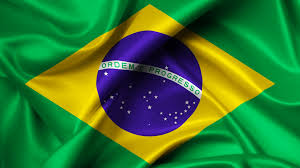

In [105]:
!pip install pydot

In [107]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

FileNotFoundError: [WinError 2] "twopi" not found in path.

<Figure size 1500x1000 with 0 Axes>


### Conclusion

What I have learned form this is that they are a lot of algorithms that we can use for this situation. What I like about this assignment is that it gaves me personnaly a chance to look at all the possible things that I could do. Before starting this assignemnt, I had in mind of what you usually say in class, I quote you: **if there is something that you need to do, probably someone has done it**. From that foundation, it helped to break down the process of doing this assigment and I found it fun to look for pieces of code, and being assisted by AI to make all the code to perfom as one system. 

The datasets themselves seems to be pretty cleaned, well maintained, and up to date.

Something about this prediction is that we first need to group stage of the WC 2026, thus the prediction will be based on more actual data, however this is for testing purpose, who knows may be that's how the WC 2026 will look like.

What could be more intersting and fun could be to predict the UEFA National League which is starting next year. Something for sure is that I will work on it and predict the winner, I just need to only use teams form Europe.